<h4>Import required libraries and set required env /global variables</h4>

In [1]:
import os
import sys
import csv

import time
import warnings
import datetime
import random
import pickle
import numpy as np
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [68]:
import torch
from torch import nn
import torch.multiprocessing
import torch.distributed as dist
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer

from transformers import AutoModel, AutoModelWithLMHead, AutoModelForCausalLM, pipeline
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from accelerate import Accelerator

In [4]:
RANDOM_SEED = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
EVAL_MODEL_1 = "jy46604790/Fake-News-Bert-Detect"
EVAL_MODEL_2 = "winterForestStump/Roberta-fake-news-detector"
BASE_MODEL_1 = "./vanilla_fakeNews_clf"
BASE_MODEL_2 = "./vanilla_fakeNews_clf_v2"

<h2>Data-preprocessing<h/2>

Visualize individual databases and then combine them

In [14]:
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")
mix_df = pd.read_csv("WELFake_Dataset.csv")

In [6]:
true_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
mix_df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [8]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
print(len(true_df), len(fake_df), len(mix_df))

21417 23481 72134


Looking at the layout of the datasets, the common features are 'text' and 'title'. Combining these 3 different datasets into a test and train dataset.

WEL_database has their label flipped. So need ot reverse that in the following helper funtion. 

In [53]:
def get_vanilla_datasets():
    true_df = pd.read_csv("True.csv")
    fake_df = pd.read_csv("Fake.csv")
    train_df = pd.read_csv("WELFake_Dataset.csv")

    # drop columns that will not be used.
    true_df = true_df.drop(columns=["subject", "date", "title"])
    fake_df = fake_df.drop(columns=["subject", "date", "title"])
    train_df = train_df.drop(columns=["Unnamed: 0", "title"])    

    # add a 'label' columns
    true_df['label'] = 1
    fake_df['label'] = 0

    # concatinate 'true' and 'fake' news datasets
    combined_df = pd.concat([true_df, fake_df])

    # clean dataframes 
    combined_df = combined_df.dropna()
    train_df = train_df.dropna()

    # flip labels for mix_df
    train_df['label'] = train_df["label"] ^ 1 # XOR operation flips 1 and 0

    # shuffle databases
    train_df = train_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    combined_df = combined_df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    split_idx = int(len(train_df) * 0.9)
    val_df = (train_df[split_idx : ]).reset_index(drop=True)
    train_df = (train_df[ : split_idx]).reset_index(drop=True)


    train_df.name = "Vanilla Train"
    val_df.name = "Vanilla Validation"
    combined_df.name = "Vanilla Test"

    return train_df, val_df, combined_df


In [84]:
def get_adversarial_datasets():
    llm_train = pd.read_csv("llm_train.csv")
    llm_test = pd.read_csv("llm_test.csv")

    llm_train = llm_train.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    llm_test = llm_test.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

    split_idx = int(len(llm_train) * 0.9)

    llm_val = (llm_train[split_idx : ]).reset_index(drop=True)
    llm_train = (llm_train[: split_idx]).reset_index(drop=True)

    llm_train.name = "Adv-LLM Train"
    llm_val.name = "Adv-LLM Validation"
    llm_test.name = "Adv-LLM Test"

    # reset index and shuffle data
    return llm_train, llm_val, llm_test

def get_mix_datasets():

    llm_train, llm_val, llm_test = get_adversarial_datasets()
    van_train, van_val, van_test = get_vanilla_datasets()

    # drop 'text' column from adversarial ds
    llm_train.drop('text', axis=1, inplace=True)
    llm_val.drop('text', axis=1, inplace=True)
    llm_test.drop('text', axis=1, inplace=True)

    # rename 'llm-text' to 'text'
    llm_train.rename(columns={'llm-text': 'text'}, inplace=True)
    llm_val.rename(columns={'llm-text': 'text'}, inplace=True)
    llm_test.rename(columns={'llm-text': 'text'}, inplace=True)

    mix_train = pd.concat([llm_train, van_train], ignore_index=True)
    mix_val = pd.concat([llm_val, van_val], ignore_index=True)
    mix_test = pd.concat([llm_test, van_test], ignore_index=True)

    return mix_train, mix_val, mix_test

def get_full_llm_dataset():
    llm_train = pd.read_csv("llm_train.csv")
    llm_test = pd.read_csv("llm_test.csv")

    llm_full = pd.concat([llm_train, llm_test], ignore_index=True)

    return llm_full

In [71]:
llm_train, llm_val, llm_test = get_adversarial_datasets()
van_train, van_val, van_test = get_vanilla_datasets()
mix_train, mix_val, mix_test = get_mix_datasets()

In [72]:
van_train.head()

,text,label
0,"by Bill Holter, JS Mineset : \nHere we are aga...",0
1,Wow! Moonbeam Johnson addresses three issues h...,0
2,21st Century Wire says Amid great mainstream ...,0
3,A massive global debt write-down of sovereign ...,0
4,WASHINGTON (Reuters) - A U.S. congressional co...,1


In [73]:
llm_train.head()

,text,llm-text,label
0,(Reuters) - The Republican tax overhaul framew...,(Reuters) - The Republican tax overhaul framew...,1
1,"Wednesday, I participated in Facebook’s meetin...","Wednesday, I participated in a meeting between...",1
2,Russia plans to test elements of new nuclear e...,"""Dear valued investors, we have an incredible ...",0
3,MOSCOW (Reuters) - Russia may decide to design...,MOSCOW (Reuters) - Russia may designate any me...,1
4,BAGHDAD (Reuters) - The Iraqi government accus...,BAGHDAD (Reuters) - The Iraqi government accus...,1


In [74]:
mix_train.head()

,text,label
0,(Reuters) - The Republican tax overhaul framew...,1
1,"Wednesday, I participated in a meeting between...",1
2,"""Dear valued investors, we have an incredible ...",0
3,MOSCOW (Reuters) - Russia may designate any me...,1
4,BAGHDAD (Reuters) - The Iraqi government accus...,1


In [66]:
print(f"length of databases : \n {van_train.name} : {len(van_train)} \n {van_val.name} : {len(van_val)} \n {van_test.name} : {len(van_test)}")

length of databases : 
 Vanilla Train : 64885 
 Vanilla Validation : 7210 
 Vanilla Test : 44898


In [67]:
print(f"length of databases : \n {llm_train.name} : {len(llm_train)} \n {llm_val.name} : {len(llm_val)} \n {llm_test.name} : {len(llm_test)}")

length of databases : 
 Adv-LLM Train : 9536 
 Adv-LLM Validation : 1060 
 Adv-LLM Test : 5736


LLM-Stylize articles to generate adversarial input. 

In [18]:
def chunk_dataframe(df, batch_size):
    for start in range(0, len(df), batch_size):
        yield df.iloc[start:start + batch_size]

In [8]:
model_id = "meta-llama/Llama-3.2-3B-Instruct" # better adherence to instructions

pipe = pipeline(
    task="text-generation", 
    model=model_id, 
    model_kwargs={"torch_dtype" : torch.bfloat16}, 
    device_map="auto",
    max_new_tokens=512,
    return_full_text=False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
def build_prompts(batch):
    messages = []

    real_prompt = "You are a writing AI assistant. Rewrite the provided text with official language. Respond only with the rewritten passage."
    fake_prompt = "You are a writing AI assistant. Rewrite the provided text like a scammer. Respond only with the rewritten passage."

    for _, (_,data) in enumerate(batch.iterrows()):
        sys_message = real_prompt if data['label'] else fake_prompt
        user_message = "Respond only with the rewritten passage. Here is the passage: \n {}. ".format(data['text'])

        message = [
            { "role" : "system", "content" : sys_message},
            { "role" : "user", "content" : user_message}
            ]
        
        messages.append(message)
    return messages

def get_llm_df(responses, batch):

    assert len(responses) == len(batch), "print len of batch and respones is not same"


    llm_responses = []
    for i in range(len(batch)):
        llm_response = responses[i][0]['generated_text']
        llm_responses.append(llm_response)

    llm_stylized_df = pd.DataFrame({
        'text' : batch['text'],
        'llm-text' : llm_responses,
        'label' : batch['label']
    })

    return llm_stylized_df


def process_batch(df, pipe_obj, batch_size):
    results = []
    for batch in chunk_dataframe(df, batch_size):
        msgs = build_prompts(batch)
        responses = pipe_obj(msgs)
        llm_df = get_llm_df(responses, batch)
        break
    return llm_df

<h2>Test a variety of models to evaluate their performance on datasets</h2>

In [18]:
def model_prediction(clf_model, text):
    encoding = clf_model.tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
    output = clf_model.model(**encoding)
    logits = output.logits
    probs = F.softmax(logits, dim=-1)
    predicted_label = torch.argmax(probs, dim=-1)
    predicted_label = predicted_label.item()

    return predicted_label


def establish_performance(model_id, df, debug=False):
    clf = pipeline("text-classification", model=model_id, tokenizer=model_id, device=DEVICE)
    count = 0
    max_len = len(df)
    if debug:
        max_len = 500
    for i in range(max_len):
        try:
            text = df['text'][i]
            res = model_prediction(clf_model=clf, text=text)
            if res == df['label'][i]:
                count += 1
        except Exception as e:
            print(f"Exception = \n {e}")
            print(f"data = \n {df['text'][i]}")

    acc = (count * 100) / max_len
    print("Accuracy of model {} on {} is {}".format(model_id, df.name, acc))
    return acc

<h5>EVAL_MODEL_1 is bert-based-uncased after being fine tuned on val-df and test_df. Performance on those datasets is expected to be much higher.</h5>

In [ ]:
establish_performance(EVAL_MODEL_1, train_df)
establish_performance(EVAL_MODEL_1, val_df)
establish_performance(EVAL_MODEL_1, test_df)
establish_performance(EVAL_MODEL_1, r2f_df)
establish_performance(EVAL_MODEL_1, f2r_df)
establish_performance(EVAL_MODEL_1, llm_df)

In [166]:
establish_performance(EVAL_MODEL_2, train_df)
establish_performance(EVAL_MODEL_2, test_df)
establish_performance(EVAL_MODEL_2, r2f_df)
establish_performance(EVAL_MODEL_2, f2r_df)
establish_performance(EVAL_MODEL_2, llm_df)

Accuracy of model winterForestStump/Roberta-fake-news-detector on vanilla trainset is 70.8
Accuracy of model winterForestStump/Roberta-fake-news-detector on vanilla test set is 84.0
Accuracy of model winterForestStump/Roberta-fake-news-detector on Real2Fake LLM dataset is 10.0
Accuracy of model winterForestStump/Roberta-fake-news-detector on Fake2Real LLM dataset is 57.5
Accuracy of model winterForestStump/Roberta-fake-news-detector on LLM Stylized dataset is 33.75


33.75

<h2> Finetune BERT </h2>

In [75]:
def finetune_bert_base(model_name, train, val, num_epochs=1):
    train_dataset = Dataset.from_pandas(train)
    val_dataset = Dataset.from_pandas(val)

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    def tokenize_function(examples):
        return tokenizer(examples['text'], padding="max_length", truncation=True)

    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)

    train_dataset = train_dataset.rename_column("label", "labels")
    val_dataset = val_dataset.rename_column("label", "labels")

    train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    training_args = TrainingArguments(
        output_dir='./results',          # Output directory for model checkpoints
        evaluation_strategy="epoch",     # Evaluate once per epoch
        learning_rate=2e-5,              # Learning rate for optimization
        per_device_train_batch_size=8,   # Batch size for training
        per_device_eval_batch_size=8,    # Batch size for evaluation
        num_train_epochs=num_epochs,              # Number of epochs
        weight_decay=0.01,               # Weight decay for regularization
        logging_dir='./logs',            # Directory for storing logs
        logging_steps=10,                # Log every 10 steps
        save_strategy="epoch",
        load_best_model_at_end=True,
        no_cuda=False,
        ddp_timeout = 120
    )

    trainer = Trainer(
        model=model,                         # The pre-trained model
        args=training_args,                  # Training arguments
        train_dataset=train_dataset,         # Training dataset
        eval_dataset=val_dataset,           # Evaluation dataset
        tokenizer=tokenizer,                 # Tokenizer for padding/truncation
    )

    trainer.train()

    model_path = "./" + model_name
    trainer.save_model(model_path)

Train model

In [ ]:
# finetune_bert_base(model_name="fakeNews_vanilla", train=van_train, val=van_val)

In [86]:
finetune_bert_base(model_name="fakeNews_adv", train=mix_train, val=mix_val)

Map:   0%|          | 0/74421 [00:00<?, ? examples/s]

Map:   0%|          | 0/8270 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/grads/a/atkulkarni/MIPS/mips/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_3263990/3747646370.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.043900,0.022592


Saving model

In [77]:
def get_predictions(model_name, df, data_col="text"):

    model_path = "./" + model_name
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    trainer = Trainer(
        model=model,
        # args=training_args,
        tokenizer=tokenizer,
    )
    # Ensure 'text' column exists
    df['text'] = df[data_col]
    test_dataset = Dataset.from_pandas(df)

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True)

    tokenized_dataset = test_dataset.map(preprocess_function, batched=True)

    predictions = trainer.predict(tokenized_dataset)
    predicted_logits = predictions.predictions
    probabilities = torch.sigmoid(torch.tensor(predicted_logits))
    predicted_labels = (probabilities >= 0.5).int()

    predicted_labels = predicted_labels.argmax(axis=1).numpy()

    return predictions, predicted_labels

def display_eval_metrics(pred_labels, df):
    # True labels from the dataset
    true_labels = df["label"].values

    # Metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

In [78]:
vanilla_predictions, vanilla_pred_labels = get_predictions("fakeNews_vanilla", van_test)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/44898 [00:00<?, ? examples/s]

In [79]:
display_eval_metrics(vanilla_pred_labels, van_test)

Accuracy: 0.9998, Precision: 0.9998, Recall: 0.9999, F1 Score: 0.9998


In [80]:
llm_predictions, llm_pred_labels = get_predictions("fakeNews_vanilla", llm_test, data_col="llm-text")

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/5736 [00:00<?, ? examples/s]

In [81]:
display_eval_metrics(llm_pred_labels, llm_test)

Accuracy: 0.8365, Precision: 0.7471, Recall: 0.9960, F1 Score: 0.8538


In [83]:
mix_predictions, mix_pred_labels = get_predictions("fakeNews_vanilla", mix_test, data_col="text")
display_eval_metrics(mix_pred_labels, mix_test)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/50634 [00:00<?, ? examples/s]

Accuracy: 0.9813, Precision: 0.9628, Recall: 0.9994, F1 Score: 0.9808


In [85]:
llm_full = get_full_llm_dataset()
llm_full_predictions, llm_full_pred_labels = get_predictions("fakeNews_vanilla", llm_full, data_col="llm-text")
display_eval_metrics(llm_full_pred_labels, llm_full)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/16332 [00:00<?, ? examples/s]

Accuracy: 0.8553, Precision: 0.7734, Recall: 0.9917, F1 Score: 0.8690


In [87]:
mix_adv_predictions, mix_adv_pred_labels = get_predictions("fakeNews_adv", mix_test, data_col="text")
display_eval_metrics(mix_adv_pred_labels, mix_test)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/50634 [00:00<?, ? examples/s]

Accuracy: 0.9992, Precision: 0.9986, Recall: 0.9998, F1 Score: 0.9992


In [88]:
llm_adv_predictions, llm_adv_pred_labels = get_predictions("fakeNews_adv", llm_test, data_col="llm-text")
display_eval_metrics(llm_adv_pred_labels, llm_test)

/tmp/ipykernel_3263990/3412914530.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Map:   0%|          | 0/5736 [00:00<?, ? examples/s]

Accuracy: 0.9965, Precision: 0.9938, Recall: 0.9989, F1 Score: 0.9964


<h2>Cosine Similarity of LLM-articles and OG-articles</h2>

In [87]:
# Initialize the Sentence-BERT model (can also use other models like 'bert-base-nli-mean-tokens')
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to compute cosine similarity
def get_cosine_similarity(article_1, article_2):
    # Encode the articles into vectors (embeddings)
    embeddings_1 = model.encode([article_1])
    embeddings_2 = model.encode([article_2])
    
    # Compute cosine similarity
    similarity = cosine_similarity(embeddings_1, embeddings_2)
    
    return similarity[0][0]

# Apply the function row-wise to compare each pair of articles
llm_full['similarity'] = llm_full.apply(lambda row: get_cosine_similarity(row['og-text'], row['llm-text']), axis=1)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [95]:
llm_full['pred_label'] = llm_pred_labels

In [96]:
llm_full.head()

,og-text,llm-text,label,text,similarity,pred_label
0,"When I was a kid, I watched a number of fights...",**URGENT: Don't Miss Out on This Life-Changing...,0,**URGENT: Don't Miss Out on This Life-Changing...,0.873264,1
1,He was such a nice boy!Where have we heard thi...,"Dear friend, I have some very disturbing news ...",0,"Dear friend, I have some very disturbing news ...",0.738115,1
2,(Reuters) - With golf long regarded as a stern...,A weekend outing between U.S. President Donald...,1,A weekend outing between U.S. President Donald...,0.963355,1
3,WELLINGTON (Reuters) - New Zealand Prime Minis...,Wellington (Reuters) - New Zealand Prime Minis...,1,Wellington (Reuters) - New Zealand Prime Minis...,0.974548,1
4,Insane! This really is the definition of insan...,Are you ready to take your civic engagement to...,0,Are you ready to take your civic engagement to...,0.763761,1


(array([  6.,   8.,   8.,   8.,  14.,  32.,  90., 198., 230., 502.]),
 array([-0.03466903,  0.0684298 ,  0.17152862,  0.27462745,  0.37772629,
         0.4808251 ,  0.58392394,  0.68702275,  0.79012156,  0.89322042,
         0.99631923]),
 <BarContainer object of 10 artists>)

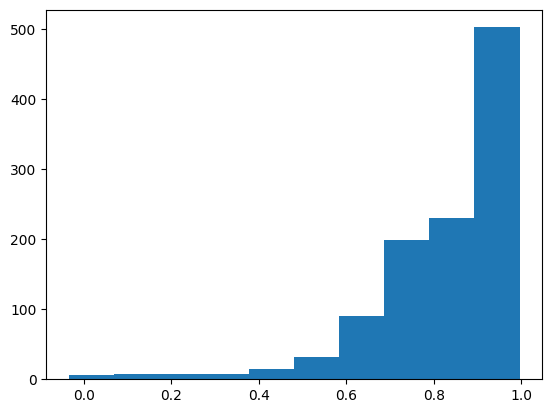

In [94]:
plt.hist(llm_full['similarity'].to_numpy())

In [107]:
llm_full

,og-text,llm-text,label,text,similarity,pred_label
0,"When I was a kid, I watched a number of fights...",**URGENT: Don't Miss Out on This Life-Changing...,0,**URGENT: Don't Miss Out on This Life-Changing...,0.873264,1
1,He was such a nice boy!Where have we heard thi...,"Dear friend, I have some very disturbing news ...",0,"Dear friend, I have some very disturbing news ...",0.738115,1
2,(Reuters) - With golf long regarded as a stern...,A weekend outing between U.S. President Donald...,1,A weekend outing between U.S. President Donald...,0.963355,1
3,WELLINGTON (Reuters) - New Zealand Prime Minis...,Wellington (Reuters) - New Zealand Prime Minis...,1,Wellington (Reuters) - New Zealand Prime Minis...,0.974548,1
4,Insane! This really is the definition of insan...,Are you ready to take your civic engagement to...,0,Are you ready to take your civic engagement to...,0.763761,1
...,...,...,...,...,...,...
1091,WASHINGTON (Reuters) - In an era of shrinking ...,WASHINGTON (Reuters) - In an era of declining ...,1,WASHINGTON (Reuters) - In an era of declining ...,0.955316,1
1092,Trump is not keeping his promises. As far as h...,**URGENT: TRUMP'S BETRAYAL EXPOSED**\n\nYou've...,0,**URGENT: TRUMP'S BETRAYAL EXPOSED**\n\nYou've...,0.759236,0
1093,While Democratic and Republicans candidates co...,"Listen up, folks, I've got the inside scoop on...",0,"Listen up, folks, I've got the inside scoop on...",0.767581,0
1094,No word yet on plans to de-fund State Departme...,**URGENT: Don't Miss This Opportunity to Suppo...,0,**URGENT: Don't Miss This Opportunity to Suppo...,0.729277,0


In [130]:
temp = llm_full[["label", "pred_label", "similarity"]]
temp2 = llm_full[["label", "pred_label", "similarity"]]

In [132]:
temp = temp[temp['label'] != temp['pred_label']]
temp2 = temp2[temp2['label'] == temp2['pred_label']]

In [128]:
temp

,label,pred_label,similarity
0,0,1,0.873264
1,0,1,0.738115
4,0,1,0.763761
7,0,1,0.708502
8,0,1,0.578636
...,...,...,...
1072,0,1,0.815115
1073,0,1,0.758664
1075,0,1,0.709202
1077,0,1,0.479807


(array([ 2.,  6.,  0.,  8., 10., 14., 42., 60., 70., 34.]),
 array([0.25427985, 0.32082707, 0.38737425, 0.45392147, 0.52046865,
        0.58701587, 0.65356308, 0.7201103 , 0.78665745, 0.85320467,
        0.91975188]),
 <BarContainer object of 10 artists>)

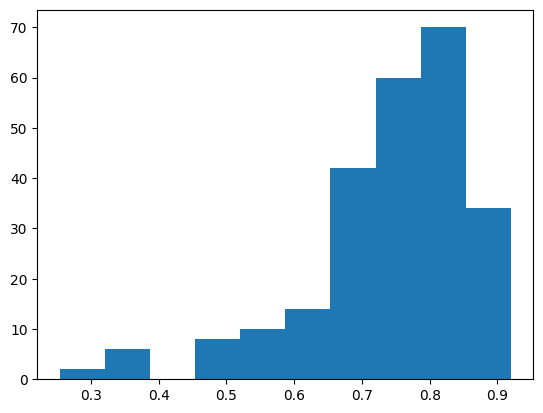

In [133]:
plt.hist(temp['similarity'])

(array([  6.,   8.,   6.,   4.,   8.,  18.,  60., 112., 134., 494.]),
 array([-0.03466903,  0.0684298 ,  0.17152862,  0.27462745,  0.37772629,
         0.4808251 ,  0.58392394,  0.68702275,  0.79012156,  0.89322042,
         0.99631923]),
 <BarContainer object of 10 artists>)

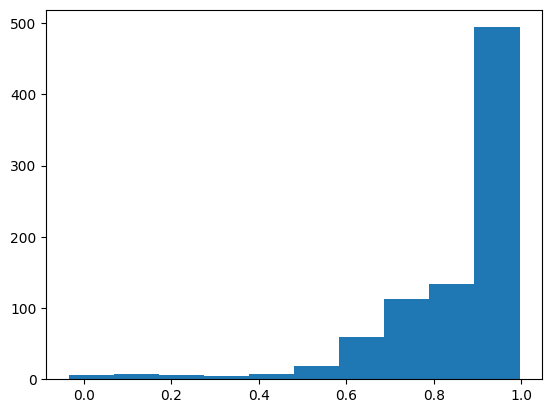

In [134]:
plt.hist(temp2['similarity'])